# SpikeClassifier
<p>
In this notebook, I'm going to build a neural net using tensorflow to train a model to identify if an object is actually a diffraction spike or not. I will use ~50 images pre-identified as spikes, and ~50 images that are not. The first thing I need to do is build my training set.

At the top I'll import some useful libraries

In [1]:
from PIL import Image
import numpy as np
import os
from random import shuffle
import matplotlib.pyplot as plt0
from tqdm import tqdm_notebook as tqdm
import requests
from io import BytesIO
from shutil import copyfile

### Moving the data around, assigning labels

I don't want to deal with the institute database all the time because I have to VPN. It's permissable for me to put the images local, so I'll do that to make things better oganized for this example. <p>


I can go to two files that have a list of URLs, one with all diffraction spike objects, one with legit high-z objects. The URLs are very informative, as they contain the name of the galaxy cluster, the data epoch, and the ID of the object.<p>

First, I must decontruct the URL to give me the path and file name of the image in the database. Then I will copy that locally and include my one hot tag, "spike". There's about ~200 of these images. <p>

Since I will do this again for the not-spike sample, I will write this up as a function

In [2]:
def copy_local_and_label(filen, label):
    """
    Gets the .png images for a given list of object URLS, and copies those images
    from the STScI RELICS server to a local directory. The objects are tagged 
    according to their label, and a list of the files is returned.
    
    Args:
        filen (str): filename for URL list of interesting objects
        label (str): The tag for these objects

    Returns:
        list: A list of the filenames after they are moved to a local directory
    
    Example:
        copy_local_and_label('/Users/bsalmon/Research/relics_photz/spikes.txt', 'spike')
    """

    from shutil import copyfile
    import pandas as pd

    df = pd.read_csv(filen, header=None)

    file_list = []
    
    for url in tqdm(df[0]):
        database_file = os.path.expandvars('$RELICS/')+url.split('private/')[1]
        database_file=database_file.replace('html/', 'html/colorstamps/IR/stamp')
        database_file=database_file.replace('.html','.png')

        cluster= url.split('private/')[1].split('/')[0]
        epoch= url.split('private/')[1].split('/')[1]
        objid=url.split('private/')[1].split('/')[-1].replace('stamp','')
        localfile = cluster+'_'+epoch+'_'+objid
        localfile = ('/Users/bsalmon/BrettSalmon/data_science/spike_not_spike/'
                     +localfile.replace('.html','_'+label+'.png'))

        if os.path.isfile(database_file):
            file_list.append(localfile)
            if not os.path.isfile(localfile):
                print('Copying to '+localfile)
                copyfile(database_file, localfile)
    return file_list

In [3]:
spike_list = copy_local_and_label('/Users/bsalmon/Research/relics_photz/spikes.txt', 'spike')

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Now I will do the same thing, but for objects that are _not_ diffraction spikes. There's about ~300 of these

In [4]:
clear_list = copy_local_and_label('/Users/bsalmon/Research/relics_photz/high-z_good_list.txt', 'clear')

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Excellent! Now I've got all the files local with one hot labels. In the future, the above commands won't do anything because I already copied the files over. 

#### Read in the images and assign one hot labels

Here I am splitting the total sample into ~75% training and ~25% testing. I am copying those file into train/ and test/ directories for book keeping. 

In [5]:
# Shuffle the training set
from random import shuffle
total_sample = list(spike_list)
total_sample.extend(clear_list)
shuffle(total_sample)

In [6]:
def clear_traintest_folders(dirname):
    """
    Deletes the files in the train or test directories    
    Args:
        dirname (str): "train" or "test"
    """
    import os, shutil
    folder = total_sample[0].split('spike_not_spike')[0]+'spike_not_spike/'+dirname
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.remove(file_path)
        except Exception as e:
            print(e)

In [9]:
# First, remove all objects from the train/ and test/ directories
clear_traintest_folders('test')
clear_traintest_folders('train')
        
split_index = round(len(total_sample)*0.75) # roughly 75% of the sample
for i in tqdm(range(len(total_sample))):
    dirname = total_sample[i].split('spike_not_spike')[0]+'spike_not_spike/'
    newfilen = (dirname+'label/'+total_sample[i].split('spike_not_spike/')[1])
    if (i+1 < split_index):
        newfilen = newfilen.replace('label', 'train')
    else:
        newfilen = newfilen.replace('label', 'test')
    copyfile(total_sample[i],newfilen)

IndexError: list index out of range

In [8]:
training_set_list = os.listdir(dirname+'/train')
testing_set_list  = os.listdir(dirname+'/test')

NameError: name 'dirname' is not defined

In [10]:
"""Note that the shape of the training set is:
       training_set = [ [img_array, label_array], 
                        [img_array, label_array], ...]
   Where img_array is 200x200 and label array is [1,0] or [0,1]
"""
import random
training_set = []
for i in tqdm(range(len(training_set_list))):
    img = Image.open(dirname+training_set_list[i]) # open image file
    img = img.convert('L') # Convert to greyscale
    img = img.resize((200, 200), Image.ANTIALIAS) # collapse into a 2D array
    if 'spike' in training_set_list[i]:
        label = [1,0]
    elif 'clear' in training_set_list[i]:
        label = [0,1]
    training_set.append([np.array(img), np.array(label)])
np.save('/Users/bsalmon/BrettSalmon/data_science/spike_not_spike/train/training_data.npy', training_set)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [11]:
"""Note that the shape of the testing set is:
       training_set = [ [img_array, label_array], 
                        [img_array, label_array], ...]
   Where img_array is 200x200 and label array is [1,0] or [0,1]
"""
import random
testing_set = []
for i in tqdm(range(len(testing_set_list))):
    img = Image.open(dirname+testing_set_list[i]) # open image file
    img = img.convert('L') # Convert to greyscale
    img = img.resize((200, 200), Image.ANTIALIAS) # collapse into a 2D array
    if 'spike' in testing_set_list[i]:
        label = [1,0]
    elif 'clear' in testing_set_list[i]:
        label = [0,1]
    testing_set.append([np.array(img), np.array(label)])
np.save('/Users/bsalmon/BrettSalmon/data_science/spike_not_spike/test/testing_data.npy', training_set)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


#### Tensorflow Town.. This bit I'm heavily relying on a tutorial

In [12]:
import tflearn

from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.reset_default_graph()

LR = 1e-3

convnet = input_data(shape=[None, 200, 200, 1], name = 'input')
convnet = conv_2d(convnet, 32, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 32, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 32, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = fully_connected(convnet, 1024, activation = 'relu')
convnet = dropout(convnet, 0.8)
convnet = fully_connected(convnet, 2, activation = 'softmax')
convnet = regression(convnet, optimizer = 'adam', learning_rate = LR, loss = 'categorical_crossentropy', name = 'targets')
model = tflearn.DNN(convnet, tensorboard_verbose=3)

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [13]:
X = np.array([i[0] for i in training_set]).reshape(-1, 200, 200, 1)
Y = [i[1] for i in training_set]

test_x = np.array([i[0] for i in testing_set]).reshape(-1, 200, 200, 1)
test_y = [i[1] for i in testing_set]

If I haven't ever ran this, then construct the model (takes a few hours) <p>
Otherwise, load the model from a previous run

In [14]:
filen = "/Users/bsalmon/BrettSalmon/data_science/spike_not_spike_model.tfl"
import os
if not os.path.exists(filen):
    model.fit({'input': X}, 
              {'targets': Y}, n_epoch=100, 
              validation_set=({'input': test_x}, 
                              {'targets': test_y}), 
              snapshot_step=50, show_metric=True, run_id='Spike_Run1')
else:
    model.load("/Users/bsalmon/BrettSalmon/data_science/spike_not_spike_model.tfl")

Training Step: 699  | total loss: 0.30551 | time: 81.397s
| Adam | epoch: 100 | loss: 0.30551 - acc: 0.9562 -- iter: 384/407
Training Step: 700  | total loss: 0.27751 | time: 109.001s
| Adam | epoch: 100 | loss: 0.27751 - acc: 0.9606 | val_loss: 0.62622 - val_acc: 0.7956 -- iter: 407/407
--


In [16]:
model.save("/Users/bsalmon/BrettSalmon/data_science/spike_not_spike_model.tfl")

INFO:tensorflow:/Users/bsalmon/BrettSalmon/data_science/spike_not_spike_model.tfl is not in all_model_checkpoint_paths. Manually adding it.


In [20]:
np.shape(training_set)

(407, 2)

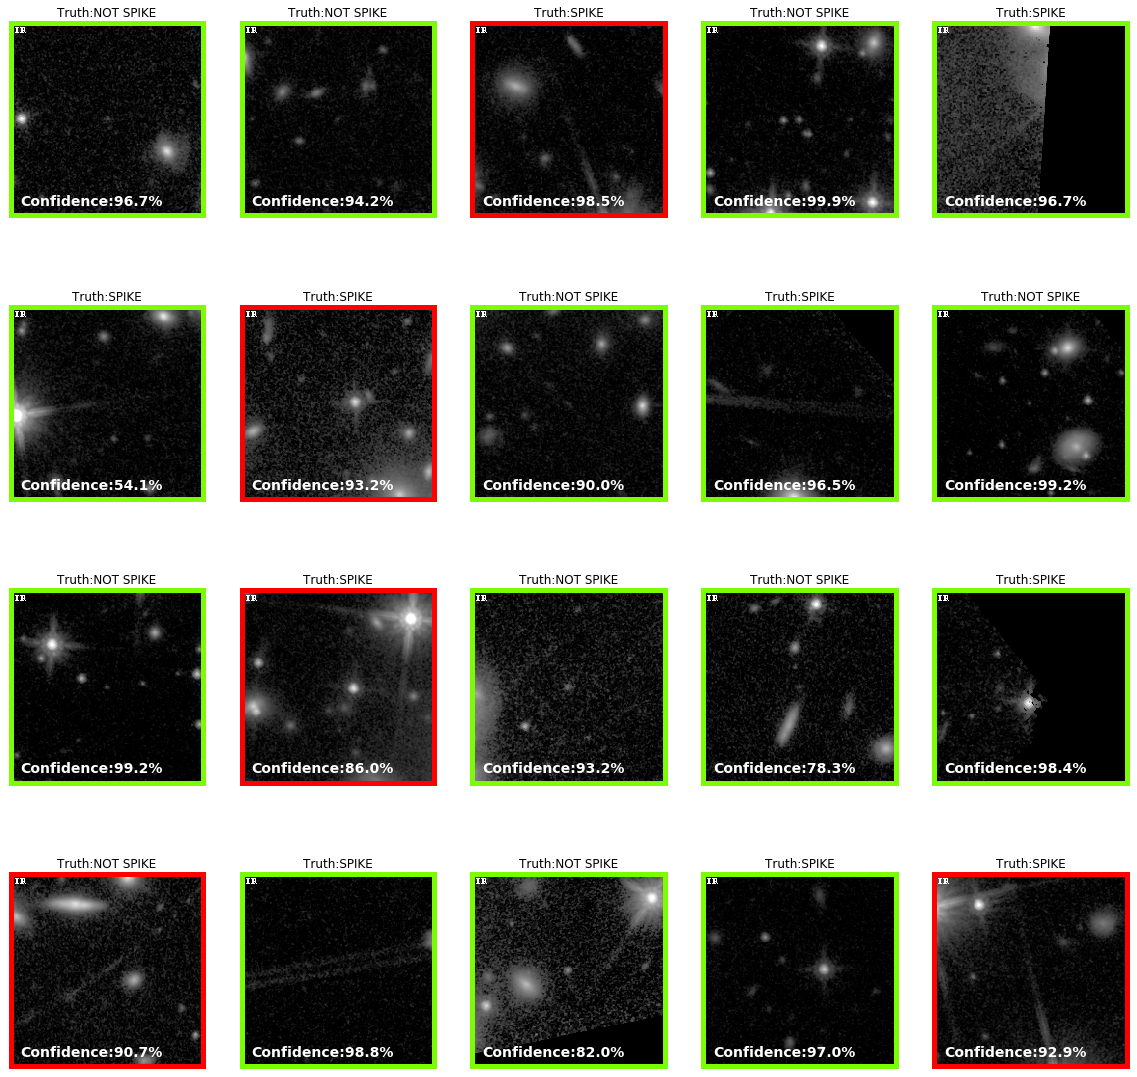

In [97]:
fig = plt.figure(figsize=[20,20])

for num, data in enumerate(testing_set[20:40]):
    img_data = data[0]
    img_label = data[1]
    if img_label[0]:
        data_text = 'Truth:SPIKE'
    else:
        data_text = 'Truth:NOT SPIKE'
    ax = fig.add_subplot(4,5,num+1)
    orig = img_data
    data = img_data.reshape(200, 200, 1)
    model_out = model.predict([data])[0]
    #print(model_out)
    if np.argmax(model_out) == 0: #index of maximum
        model_text = 'Model:SPIKE'
    else:
        model_text = 'Model:NOT SPIKE'
    
    cmap = plt.cm.get_cmap('PiYG', 11)
    ax.imshow(orig, cmap = 'gray')
    ax.set_title(data_text)#+"  "+model_text)
    #ax.axes.get_xaxis().set_visible(False)
    #ax.axes.get_yaxis().set_visible(False)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    if 0: # Tried to get fancy with a color map.. not necessary
        cmap = plt.cm.get_cmap('PiYG', 11)
        cmaplist = [cmap(i) for i in range(cmap.N)]
        bounds = np.linspace(0, 1, 11)
        norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
        from salmonscripts.findel import findel
        colorVal = cmaplist[findel(bounds,model_out[1])]
    if img_label[0]:
        if np.argmax(model_out)==0:colorcall='lawngreen'
        if np.argmax(model_out)==1:colorcall='red'
    else:
        if np.argmax(model_out)==1:colorcall='lawngreen'
        if np.argmax(model_out)==0:colorcall='red'
        
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(5)
        ax.spines[axis].set_color(colorcall)
    ax.text(0.05,0.05,"Confidence:"+"{:4.1f}".format(100*max(model_out))+"%",
            weight="bold",color='White',fontsize=14,transform=ax.transAxes)

## It does.. pretty well?
Could be better. I need to speed things up, do some K-fold cross-validation, and just like the machine learning, enhance my pre-labeled samples.


What I found pretty interesting was that it mis-labeled a bon-a-fide lensed galaxy. We want to be sure we don't miss one like this! We know it's a lense image because the arc curves.. Maybe I just need the FoV of the images to be larger.

<img src="whl0137_bigarc_colorcutout.png" alt="Drawing" style="width: 700px;"/>